In [7]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

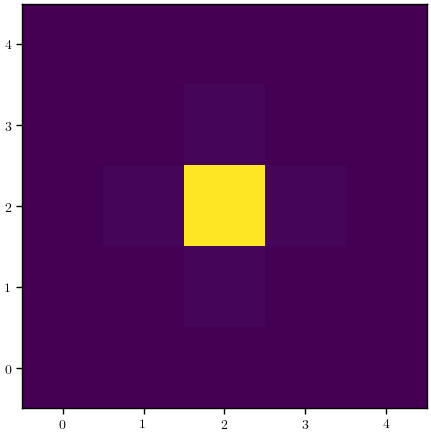

In [8]:
from lenstronomy.Data.psf import PSF

fwhm = 0.087
pixel_scale = 0.11
oversample = 5

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': pixel_scale, 'truncation': 6}
psf_class = PSF(**kwargs_psf)

gaussian_psf = psf_class.kernel_pixel

plt.imshow(gaussian_psf)
plt.show()

In [9]:
oversampled_pixel_scale = pixel_scale / oversample
psf_image = galsim.Image(psf_class.kernel_pixel, scale=oversampled_pixel_scale)
gaussian_interp = galsim.InterpolatedImage(psf_image)

In [10]:
from mejiro.helpers import psf

webbpsf_interp = psf.get_webbpsf_psf('F106', detector=1, detector_position=(2048, 2048), oversample=5,
                                             check_cache=True, suppress_output=False)

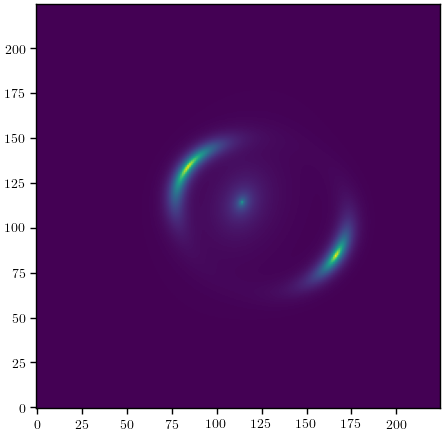

In [11]:
lens = SampleStrongLens()
band = 'F106'
model = lens.get_array(num_pix = 45 * 5, side=4.95, band=band)

plt.imshow(model)
plt.show()

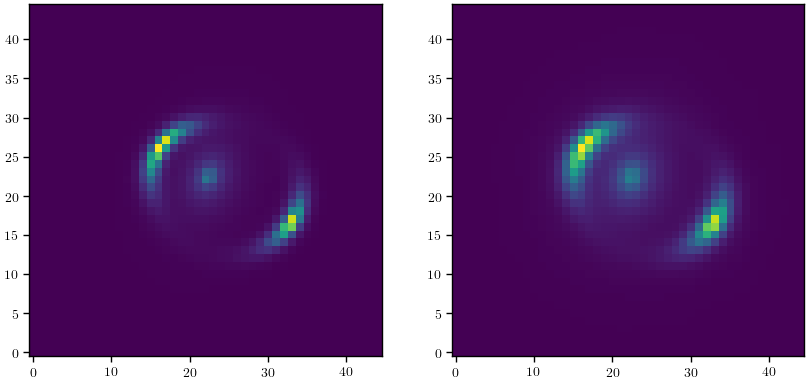

In [12]:
total_flux_cps = lens.get_total_flux_cps(band)
interp = galsim.InterpolatedImage(galsim.Image(model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps * 146)

image_gaussian = gs.convolve(interp, gaussian_interp, 45)
image_webbpsf = gs.convolve(interp, webbpsf_interp, 45)

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_gaussian.array)
ax[1].imshow(image_webbpsf.array)
plt.show()